In [1]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_set = datasets.MNIST(
    download=True,
    root='Data',
    train=True,
    transform=ToTensor(),
)

test_set = datasets.MNIST(
    download=True,
    root='Data',
    train=False,
    transform=ToTensor(),
)

In [9]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.flatten = nn.Flatten(1, -1)
        self.layer1 = nn.Linear(784, 100)
        self.layer2 = nn.Linear(100, 10)
    def forward(self, x):
        x = self.flatten(x)
        x = nn.functional.relu(self.layer1(x))
        x = nn.functional.softmax(self.layer2(x), dim=1)
        return x

In [10]:
# Do not change this cell
def caluculate_acc(data, model, length):
  model.eval()
  acc = 0
  for images, label in data:
    with torch.no_grad():
      images = images.to(device)
      label = label.to(device)
      yp = model(images)
      yp = torch.nn.functional.softmax(yp, dim=1)
      yp = torch.argmax(yp, 1)
      acc += torch.sum(yp == label)
  return acc / length

In [11]:
# Do not change this cell
def train_one_epoch(model, data, optimizer, criterion, length):
  model.train()
  acc = 0
  for images, labels in data:
    imgs = torch.autograd.Variable(images).to(device)
    label = torch.autograd.Variable(labels).to(device)
    optimizer.zero_grad()
    yp = model(imgs)
    loss = criterion(yp, label)
    loss.backward()
    optimizer.step()
    yp = torch.argmax(yp, 1)
    acc += torch.sum(yp == label)
  return loss.item(), acc / length

In [12]:
model = Model().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

# model summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
            Linear-3                   [-1, 10]           1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


/var/folders/bd/4lflpjc116l_jkfv7vy18qkw0000gn/T/ipykernel_4299/2213283667.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(self.layer2(x))


In [16]:
# training process
val_accs = []
accs = []
best_acc = 0
for e in tqdm(range(20)):
  accs.append(train_one_epoch(model, train_loader, optimizer, criterion, len(train_set))[1].item())
  val_accs.append(caluculate_acc(test_loader, model, len(test_set)).item())
  print(f"epoch {e}: accuracy:{accs[-1]} val_accuracy:{val_accs[-1]}")
  if best_acc < val_accs[-1]:
    torch.save(model, "model.h5")
    best_Acc = val_accs[-1]
  
  # just a way to avoid pverfitting
  if val_accs[-1] > 0.99 and accs[-1] > 0.99:
    break

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/bd/4lflpjc116l_jkfv7vy18qkw0000gn/T/ipykernel_4299/2213283667.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(self.layer2(x))


epoch 0: accuracy:0.9899166822433472 val_accuracy:0.9754999876022339
epoch 1: accuracy:0.9898166656494141 val_accuracy:0.9757999777793884
epoch 2: accuracy:0.9904500246047974 val_accuracy:0.9768999814987183
epoch 3: accuracy:0.9905333518981934 val_accuracy:0.9753999710083008
epoch 4: accuracy:0.991016685962677 val_accuracy:0.9753999710083008
epoch 5: accuracy:0.9912166595458984 val_accuracy:0.9750999808311462
epoch 6: accuracy:0.9917666912078857 val_accuracy:0.9754999876022339
epoch 7: accuracy:0.9920666813850403 val_accuracy:0.9746000170707703
epoch 8: accuracy:0.9920166730880737 val_accuracy:0.9757000207901001
epoch 9: accuracy:0.9921666383743286 val_accuracy:0.9767000079154968
epoch 10: accuracy:0.9924166798591614 val_accuracy:0.9763000011444092
epoch 11: accuracy:0.9924499988555908 val_accuracy:0.9746000170707703
epoch 12: accuracy:0.9924666881561279 val_accuracy:0.9761000275611877
epoch 13: accuracy:0.992816686630249 val_accuracy:0.9761000275611877
epoch 14: accuracy:0.99248331785

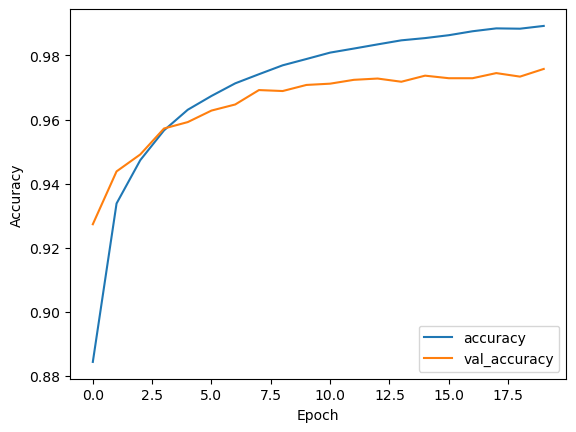

In [14]:
plt.plot(accs, label='accuracy')
plt.plot(val_accs, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show();

In [15]:
caluculate_acc(test_loader, model, len(test_set)).item(), caluculate_acc(train_loader, model, len(train_set)).item()

/var/folders/bd/4lflpjc116l_jkfv7vy18qkw0000gn/T/ipykernel_4299/2213283667.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(self.layer2(x))


(0.9757999777793884, 0.9903500080108643)